In [15]:
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import Label
from urllib.request import urlopen
from urllib.error import HTTPError
import pickle
import requests
import datetime as dt
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import wordnet
import numpy as np
import gzip
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sb
import pyLDAvis.sklearn

# Reading in data

In this version of LDA, to visual the data how we would like we needed to switch packages from Gensim to sklearn's LatentDirichletAllocation package. This meant we have to do some preprocess of the data now instead of simply loading the pickle files as before. Hence we read in our data from Github and perform regex to remove punctuation, symbols, etc in our data so we can tokenise our data and effectively make our corpus again. We then aimed to before some dimensionality reduction to see how this would effect our results.

In [2]:
df = pd.read_csv("https://github.com/Galeforse/DST-Assessment-03/raw/master/Data/master_log_5.csv.gz")
data_text=df[['log']]
data_text['index']=data_text.index
print(data_text[:5])
print(len(data_text))



                                                 log  index
0  Jan  5 03:23:54 161.166.1.23 sshd[27076]: Fail...      0
1  Jan  5 03:24:25 161.166.1.23 sshd[27087]: Disc...      1
2  Jan  5 03:24:27 161.166.1.23 sshd[27090]: pam_...      2
3  Jan  5 04:08:21 161.166.1.23 sshd[27590]: pam_...      3
4  Jan  5 04:08:59 161.166.1.23 sshd[27598]: Fail...      4
794026


# Regex

In [3]:
import re
def regex(text):
    text = re.sub(r"[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+"," ",text)
    text = re.sub(r"[0-9]{2}\:[0-9]{2}\:[0-9]{2}"," ",text)
    text = re.sub(r'\d+'," ",text)
    text = re.sub(r"[^A-Za-z0-9 ]+"," ",text)
    text = re.sub(r"XXXXX"," ",text)
    text = re.sub(r"sshd"," ",text)
    return text

In [4]:
doc = data_text['log']
doc.head()

0    Jan  5 03:23:54 161.166.1.23 sshd[27076]: Fail...
1    Jan  5 03:24:25 161.166.1.23 sshd[27087]: Disc...
2    Jan  5 03:24:27 161.166.1.23 sshd[27090]: pam_...
3    Jan  5 04:08:21 161.166.1.23 sshd[27590]: pam_...
4    Jan  5 04:08:59 161.166.1.23 sshd[27598]: Fail...
Name: log, dtype: object

In [5]:
process = doc.map(regex)

In [6]:
process.head()

0    Jan             Failed password for   from   p...
1    Jan             Disconnecting  Too many authen...
2    Jan             pam unix   auth  authenticatio...
3    Jan             pam unix   auth  authenticatio...
4    Jan             Failed password for   from   p...
Name: log, dtype: object

We use CountVectorizer to count the number of times a word occurs in our corpus. We then want to learn the dictionary and return a document-term matrix.

In [7]:
data_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
data_document_term_matrix = data_count_vectorizer.fit_transform(process)
n_topics=10

We know have all we know to train our LDA model again using the sklearn LDA package this time and then fit this to a topic matrix.

In [8]:
lda_model2 = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0,verbose=0)
lda_topic_matrix = lda_model2.fit_transform(data_document_term_matrix)

In [9]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)




lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

Here we decided to do some dimensionality reduction use t-Distributed Stochastic Neighbour Embedding (t-SNE) which minimises the divergence between two distributions. t-SNE maps the multi-dimensional data to a lower dimensional space and analyses any observed clusters based off the similarity of data points which feature multiple times. After this however, no inferences can be made as the input features cannot be identified anymore, hence why we are using it to mainly to try and visualise our data, allowing us to hopefully some conclusions. 

In [10]:
tsne_lda_model2 = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model2.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 794026 samples in 95.541s...
[t-SNE] Computed neighbors for 794026 samples in 796.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 794026
[t-SNE] Computed conditional probabilities for sample 2000 / 794026
[t-SNE] Computed conditional probabilities for sample 3000 / 794026
[t-SNE] Computed conditional probabilities for sample 4000 / 794026
[t-SNE] Computed conditional probabilities for sample 5000 / 794026
[t-SNE] Computed conditional probabilities for sample 6000 / 794026
[t-SNE] Computed conditional probabilities for sample 7000 / 794026
[t-SNE] Computed conditional probabilities for sample 8000 / 794026
[t-SNE] Computed conditional probabilities for sample 9000 / 794026
[t-SNE] Computed conditional probabilities for sample 10000 / 794026
[t-SNE] Computed conditional probabilities for sample 11000 / 794026
[t-SNE] Computed conditional probabilities for sample 12000 / 794026
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities for sample 118000 / 794026
[t-SNE] Computed conditional probabilities for sample 119000 / 794026
[t-SNE] Computed conditional probabilities for sample 120000 / 794026
[t-SNE] Computed conditional probabilities for sample 121000 / 794026
[t-SNE] Computed conditional probabilities for sample 122000 / 794026
[t-SNE] Computed conditional probabilities for sample 123000 / 794026
[t-SNE] Computed conditional probabilities for sample 124000 / 794026
[t-SNE] Computed conditional probabilities for sample 125000 / 794026
[t-SNE] Computed conditional probabilities for sample 126000 / 794026
[t-SNE] Computed conditional probabilities for sample 127000 / 794026
[t-SNE] Computed conditional probabilities for sample 128000 / 794026
[t-SNE] Computed conditional probabilities for sample 129000 / 794026
[t-SNE] Computed conditional probabilities for sample 130000 / 794026
[t-SNE] Computed conditional probabilities for sample 131000 / 794026
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 239000 / 794026
[t-SNE] Computed conditional probabilities for sample 240000 / 794026
[t-SNE] Computed conditional probabilities for sample 241000 / 794026
[t-SNE] Computed conditional probabilities for sample 242000 / 794026
[t-SNE] Computed conditional probabilities for sample 243000 / 794026
[t-SNE] Computed conditional probabilities for sample 244000 / 794026
[t-SNE] Computed conditional probabilities for sample 245000 / 794026
[t-SNE] Computed conditional probabilities for sample 246000 / 794026
[t-SNE] Computed conditional probabilities for sample 247000 / 794026
[t-SNE] Computed conditional probabilities for sample 248000 / 794026
[t-SNE] Computed conditional probabilities for sample 249000 / 794026
[t-SNE] Computed conditional probabilities for sample 250000 / 794026
[t-SNE] Computed conditional probabilities for sample 251000 / 794026
[t-SNE] Computed conditional probabilities for sample 252000 / 794026
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 359000 / 794026
[t-SNE] Computed conditional probabilities for sample 360000 / 794026
[t-SNE] Computed conditional probabilities for sample 361000 / 794026
[t-SNE] Computed conditional probabilities for sample 362000 / 794026
[t-SNE] Computed conditional probabilities for sample 363000 / 794026
[t-SNE] Computed conditional probabilities for sample 364000 / 794026
[t-SNE] Computed conditional probabilities for sample 365000 / 794026
[t-SNE] Computed conditional probabilities for sample 366000 / 794026
[t-SNE] Computed conditional probabilities for sample 367000 / 794026
[t-SNE] Computed conditional probabilities for sample 368000 / 794026
[t-SNE] Computed conditional probabilities for sample 369000 / 794026
[t-SNE] Computed conditional probabilities for sample 370000 / 794026
[t-SNE] Computed conditional probabilities for sample 371000 / 794026
[t-SNE] Computed conditional probabilities for sample 372000 / 794026
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 480000 / 794026
[t-SNE] Computed conditional probabilities for sample 481000 / 794026
[t-SNE] Computed conditional probabilities for sample 482000 / 794026
[t-SNE] Computed conditional probabilities for sample 483000 / 794026
[t-SNE] Computed conditional probabilities for sample 484000 / 794026
[t-SNE] Computed conditional probabilities for sample 485000 / 794026
[t-SNE] Computed conditional probabilities for sample 486000 / 794026
[t-SNE] Computed conditional probabilities for sample 487000 / 794026
[t-SNE] Computed conditional probabilities for sample 488000 / 794026
[t-SNE] Computed conditional probabilities for sample 489000 / 794026
[t-SNE] Computed conditional probabilities for sample 490000 / 794026
[t-SNE] Computed conditional probabilities for sample 491000 / 794026
[t-SNE] Computed conditional probabilities for sample 492000 / 794026
[t-SNE] Computed conditional probabilities for sample 493000 / 794026
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 601000 / 794026
[t-SNE] Computed conditional probabilities for sample 602000 / 794026
[t-SNE] Computed conditional probabilities for sample 603000 / 794026
[t-SNE] Computed conditional probabilities for sample 604000 / 794026
[t-SNE] Computed conditional probabilities for sample 605000 / 794026
[t-SNE] Computed conditional probabilities for sample 606000 / 794026
[t-SNE] Computed conditional probabilities for sample 607000 / 794026
[t-SNE] Computed conditional probabilities for sample 608000 / 794026
[t-SNE] Computed conditional probabilities for sample 609000 / 794026
[t-SNE] Computed conditional probabilities for sample 610000 / 794026
[t-SNE] Computed conditional probabilities for sample 611000 / 794026
[t-SNE] Computed conditional probabilities for sample 612000 / 794026
[t-SNE] Computed conditional probabilities for sample 613000 / 794026
[t-SNE] Computed conditional probabilities for sample 614000 / 794026
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 720000 / 794026
[t-SNE] Computed conditional probabilities for sample 721000 / 794026
[t-SNE] Computed conditional probabilities for sample 722000 / 794026
[t-SNE] Computed conditional probabilities for sample 723000 / 794026
[t-SNE] Computed conditional probabilities for sample 724000 / 794026
[t-SNE] Computed conditional probabilities for sample 725000 / 794026
[t-SNE] Computed conditional probabilities for sample 726000 / 794026
[t-SNE] Computed conditional probabilities for sample 727000 / 794026
[t-SNE] Computed conditional probabilities for sample 728000 / 794026
[t-SNE] Computed conditional probabilities for sample 729000 / 794026
[t-SNE] Computed conditional probabilities for sample 730000 / 794026
[t-SNE] Computed conditional probabilities for sample 731000 / 794026
[t-SNE] Computed conditional probabilities for sample 732000 / 794026
[t-SNE] Computed conditional probabilities for sample 733000 / 794026
[t-SNE] Computed con

In [11]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])
show(plot)

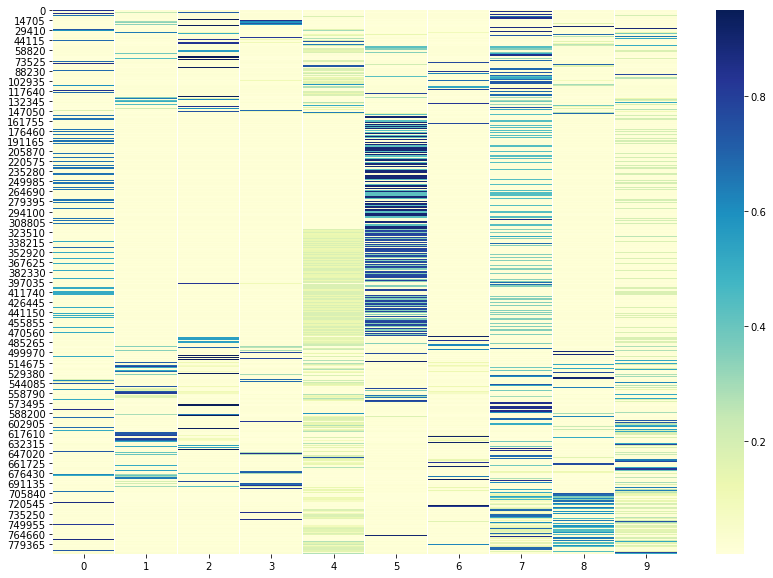

In [12]:
fig, ax = plt.subplots(figsize=(14,10))
sb.heatmap(lda_topic_matrix, cmap="YlGnBu", ax=ax);
plt.show()

In [14]:
corpus=pickle.load(urlopen('https://github.com/Galeforse/DST-Assessment-03/raw/master/Data/main/corpus_5.pkl'))


log_perplexitites = {'lda_model2': lda_model2.perplexity(corpus),
                     'tsne_lda_model2': tsne_lda_vectors.perplexity(corpus)}

log_perplexitites 


ValueError: Expected 2D array, got 1D array instead:
array=[list([(0, 1), (1, 1), (2, 1)]) list([(3, 1), (4, 1), (5, 1), (6, 1)])
 list([(4, 1), (5, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)])
 ... list([(96, 1), (129, 1), (227, 1), (281, 1)])
 list([(13, 1), (23, 1)]) list([(13, 1), (23, 1)])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.